# cheias.pt — Data Source Exploration

**Test location:** Alcácer do Sal (38.3728°N, 8.5103°W), Sado basin  
**Why this location:** Actively flooding in February 2026 — any data source that doesn't flag it is broken.  
**Date:** 2026-02-10

This notebook validates every data source identified during discovery before committing to architecture.

---

In [35]:
# === SHARED SETUP ===
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Test location: Alcácer do Sal, Sado basin
LAT, LON = 38.3728, -8.5103
LOCATION_NAME = "Alcácer do Sal"

# Sado river point (downstream of Alcácer, for discharge queries)
# GloFAS grid is ~5km, so we use a point on the main Sado channel
SADO_LAT, SADO_LON = 38.37, -8.52

# IPMA district code for Setúbal
SETUBAL_DISTRICT = "STB"

# Typical soil porosity for Sado basin (sandy-clay soils)
POROSITY = 0.42

TODAY = datetime.now().strftime("%Y-%m-%d")
print(f"Exploring data for {LOCATION_NAME} ({LAT}, {LON})")
print(f"Date: {TODAY}")

Exploring data for Alcácer do Sal (38.3728, -8.5103)
Date: 2026-02-11


---
## 1. Open-Meteo Soil Moisture

**Question:** Is the ground saturated after weeks of rain?  
**Source:** Open-Meteo Forecast API (NWP model soil moisture) + Historical API (ERA5-Land)  
**Expected:** Values near porosity (~0.40–0.45 m³/m³) indicating saturation.

In [36]:
# --- 1a. Current + recent soil moisture from forecast API (includes past_days) ---

sm_url = "https://api.open-meteo.com/v1/forecast"
sm_params = {
    "latitude": LAT,
    "longitude": LON,
    "hourly": ",".join([
        "soil_moisture_0_to_1cm",
        "soil_moisture_1_to_3cm",
        "soil_moisture_3_to_9cm",
        "soil_moisture_9_to_27cm",
        "soil_moisture_27_to_81cm",
    ]),
    "past_days": 14,
    "forecast_days": 7,
}

resp = requests.get(sm_url, params=sm_params)
resp.raise_for_status()
sm_data = resp.json()

print(f"Model grid point: {sm_data['latitude']:.2f}°N, {sm_data['longitude']:.2f}°W")
print(f"Elevation: {sm_data.get('elevation', 'N/A')}m")
print(f"Data range: {sm_data['hourly']['time'][0]} → {sm_data['hourly']['time'][-1]}")
print(f"Hours: {len(sm_data['hourly']['time'])}")

Model grid point: 38.38°N, -8.50°W
Elevation: 40.0m
Data range: 2026-01-28T00:00 → 2026-02-17T23:00
Hours: 504


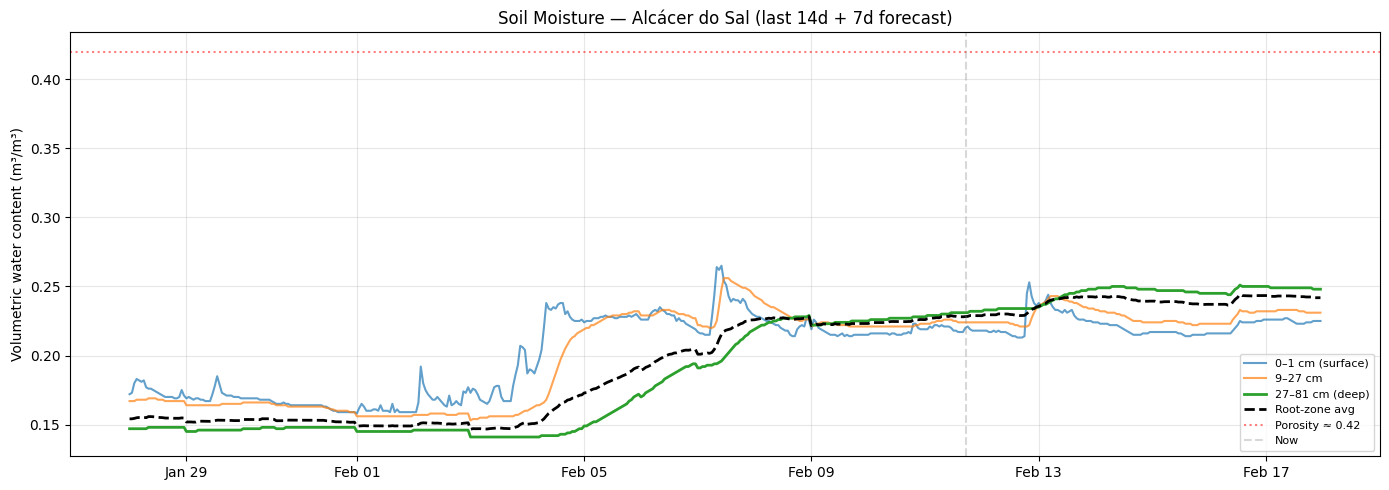


--- Latest soil moisture ---
  sm_0_1         : 0.2250 m³/m³  (54% of capacity)
  sm_9_27        : 0.2310 m³/m³  (55% of capacity)
  sm_27_81       : 0.2480 m³/m³  (59% of capacity)
  sm_rootzone    : 0.2418 m³/m³  (58% of capacity)


In [37]:
# --- 1b. Parse into DataFrame and visualize ---

sm_df = pd.DataFrame({
    "time": pd.to_datetime(sm_data["hourly"]["time"]),
    "sm_0_1": sm_data["hourly"]["soil_moisture_0_to_1cm"],
    "sm_1_3": sm_data["hourly"]["soil_moisture_1_to_3cm"],
    "sm_3_9": sm_data["hourly"]["soil_moisture_3_to_9cm"],
    "sm_9_27": sm_data["hourly"]["soil_moisture_9_to_27cm"],
    "sm_27_81": sm_data["hourly"]["soil_moisture_27_to_81cm"],
}).set_index("time")

# Compute a root-zone average (weighted by layer thickness)
# Layers: 1cm, 2cm, 6cm, 18cm, 54cm = 81cm total
weights = np.array([1, 2, 6, 18, 54]) / 81
sm_df["sm_rootzone"] = (
    sm_df["sm_0_1"] * weights[0]
    + sm_df["sm_1_3"] * weights[1]
    + sm_df["sm_3_9"] * weights[2]
    + sm_df["sm_9_27"] * weights[3]
    + sm_df["sm_27_81"] * weights[4]
)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(sm_df.index, sm_df["sm_0_1"], label="0–1 cm (surface)", alpha=0.7)
ax.plot(sm_df.index, sm_df["sm_9_27"], label="9–27 cm", alpha=0.7)
ax.plot(sm_df.index, sm_df["sm_27_81"], label="27–81 cm (deep)", linewidth=2)
ax.plot(sm_df.index, sm_df["sm_rootzone"], label="Root-zone avg", linewidth=2, color="black", linestyle="--")
ax.axhline(y=POROSITY, color="red", linestyle=":", alpha=0.5, label=f"Porosity ≈ {POROSITY}")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.3, label="Now")
ax.set_ylabel("Volumetric water content (m³/m³)")
ax.set_title(f"Soil Moisture — {LOCATION_NAME} (last 14d + 7d forecast)")
ax.legend(loc="lower right", fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary stats
latest = sm_df.dropna().iloc[-1]
print(f"\n--- Latest soil moisture ---")
for col in ["sm_0_1", "sm_9_27", "sm_27_81", "sm_rootzone"]:
    val = latest[col]
    pct = val / POROSITY * 100
    print(f"  {col:15s}: {val:.4f} m³/m³  ({pct:.0f}% of capacity)")

---
## 2. Precipitation — Antecedent + Forecast

**Question:** How much rain has fallen recently, and how much is coming?  
**Source:** Open-Meteo Forecast API (past_days + forecast)  
**Expected:** High antecedent rainfall (weeks of wet weather) + potentially more coming.

In [38]:
# --- 2a. Precipitation: past 14 days + 7-day forecast ---

precip_url = "https://api.open-meteo.com/v1/forecast"
precip_params = {
    "latitude": LAT,
    "longitude": LON,
    "hourly": "precipitation,precipitation_probability",
    "daily": "precipitation_sum,precipitation_probability_max",
    "past_days": 14,
    "forecast_days": 7,
}

resp = requests.get(precip_url, params=precip_params)
resp.raise_for_status()
precip_data = resp.json()

# Daily summary
daily_df = pd.DataFrame({
    "date": pd.to_datetime(precip_data["daily"]["time"]),
    "precip_mm": precip_data["daily"]["precipitation_sum"],
    "prob_max": precip_data["daily"].get("precipitation_probability_max"),
}).set_index("date")

# Hourly for rolling sums
hourly_df = pd.DataFrame({
    "time": pd.to_datetime(precip_data["hourly"]["time"]),
    "precip_mm": precip_data["hourly"]["precipitation"],
}).set_index("time")

# Rolling sums
hourly_df["rolling_24h"] = hourly_df["precip_mm"].rolling(24).sum()
hourly_df["rolling_72h"] = hourly_df["precip_mm"].rolling(72).sum()
hourly_df["rolling_7d"] = hourly_df["precip_mm"].rolling(168).sum()
hourly_df["cumulative"] = hourly_df["precip_mm"].cumsum()

print(f"=== Precipitation Summary — {LOCATION_NAME} ===")
past_total = daily_df["precip_mm"][:14].sum()
future_total = daily_df["precip_mm"][14:].sum()
print(f"Last 14 days accumulated: {past_total:.1f} mm")
print(f"Next 7 days forecast:     {future_total:.1f} mm")
print(f"Total 21-day window:      {past_total + future_total:.1f} mm")

=== Precipitation Summary — Alcácer do Sal ===
Last 14 days accumulated: 184.3 mm
Next 7 days forecast:     26.1 mm
Total 21-day window:      210.4 mm


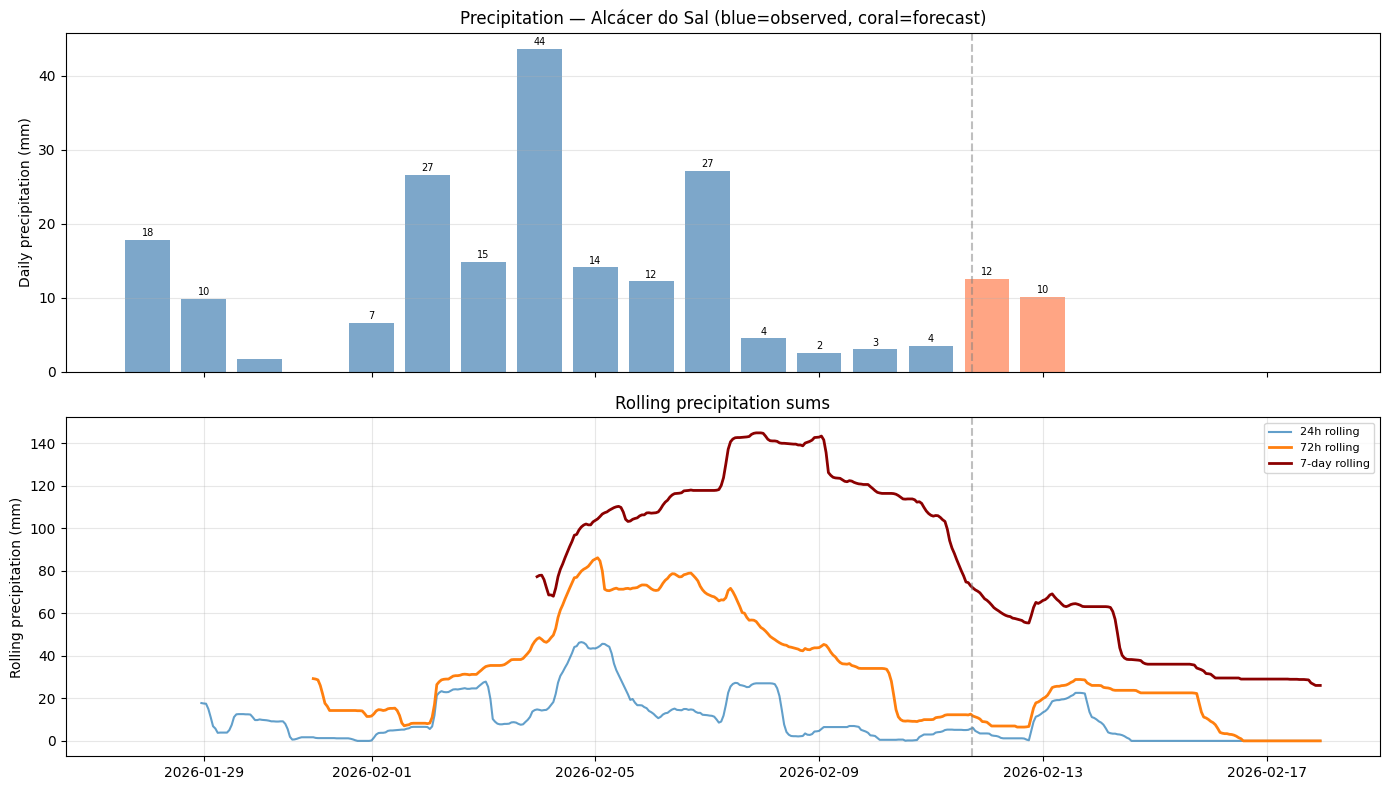


--- Daily breakdown ---
  2026-01-28:   17.8 mm ████████ 
  2026-01-29:    9.8 mm ████ 
  2026-01-30:    1.7 mm  
  2026-01-31:    0.0 mm  
  2026-02-01:    6.6 mm ███ 
  2026-02-02:   26.6 mm █████████████ 
  2026-02-03:   14.8 mm ███████ 
  2026-02-04:   43.6 mm █████████████████████ 
  2026-02-05:   14.1 mm ███████ 
  2026-02-06:   12.2 mm ██████ 
  2026-02-07:   27.1 mm █████████████ 
  2026-02-08:    4.5 mm ██ 
  2026-02-09:    2.5 mm █ 
  2026-02-10:    3.0 mm █ 
  2026-02-11:    3.5 mm █ ◀ today
  2026-02-12:   12.5 mm ██████ 
  2026-02-13:   10.1 mm █████ 
  2026-02-14:    0.0 mm  
  2026-02-15:    0.0 mm  
  2026-02-16:    0.0 mm  
  2026-02-17:    0.0 mm  


In [39]:
# --- 2b. Visualize daily precip + rolling sums ---

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: daily bars
ax = axes[0]
colors = ["steelblue" if d < pd.Timestamp.now() else "coral" for d in daily_df.index]
ax.bar(daily_df.index, daily_df["precip_mm"], color=colors, alpha=0.7, width=0.8)
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Daily precipitation (mm)")
ax.set_title(f"Precipitation — {LOCATION_NAME} (blue=observed, coral=forecast)")
ax.grid(True, alpha=0.3, axis="y")

# Annotate daily totals
for d, row in daily_df.iterrows():
    if row["precip_mm"] and row["precip_mm"] > 2:
        ax.text(d, row["precip_mm"] + 0.5, f"{row['precip_mm']:.0f}", ha="center", fontsize=7)

# Bottom: rolling sums
ax = axes[1]
ax.plot(hourly_df.index, hourly_df["rolling_24h"], label="24h rolling", alpha=0.7)
ax.plot(hourly_df.index, hourly_df["rolling_72h"], label="72h rolling", linewidth=2)
ax.plot(hourly_df.index, hourly_df["rolling_7d"], label="7-day rolling", linewidth=2, color="darkred")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Rolling precipitation (mm)")
ax.set_title("Rolling precipitation sums")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Daily table
print("\n--- Daily breakdown ---")
for d, row in daily_df.iterrows():
    marker = "◀ today" if d.date() == pd.Timestamp.now().date() else ""
    bar = "█" * int((row["precip_mm"] or 0) / 2)
    print(f"  {d.strftime('%Y-%m-%d')}: {row['precip_mm']:6.1f} mm {bar} {marker}")

---
## 3. Open-Meteo Flood API — Sado River Discharge

**Question:** Is the Sado river elevated compared to historical norms?  
**Source:** Open-Meteo Flood API (wraps GloFAS)  
**Expected:** Discharge well above median after sustained rainfall.  

Note: The Flood API finds the nearest GloFAS river segment. The Sado near Alcácer do Sal should
be a major enough river to appear in the 5km GloFAS grid.

GloFAS grid point: 38.375°N, -8.525°W


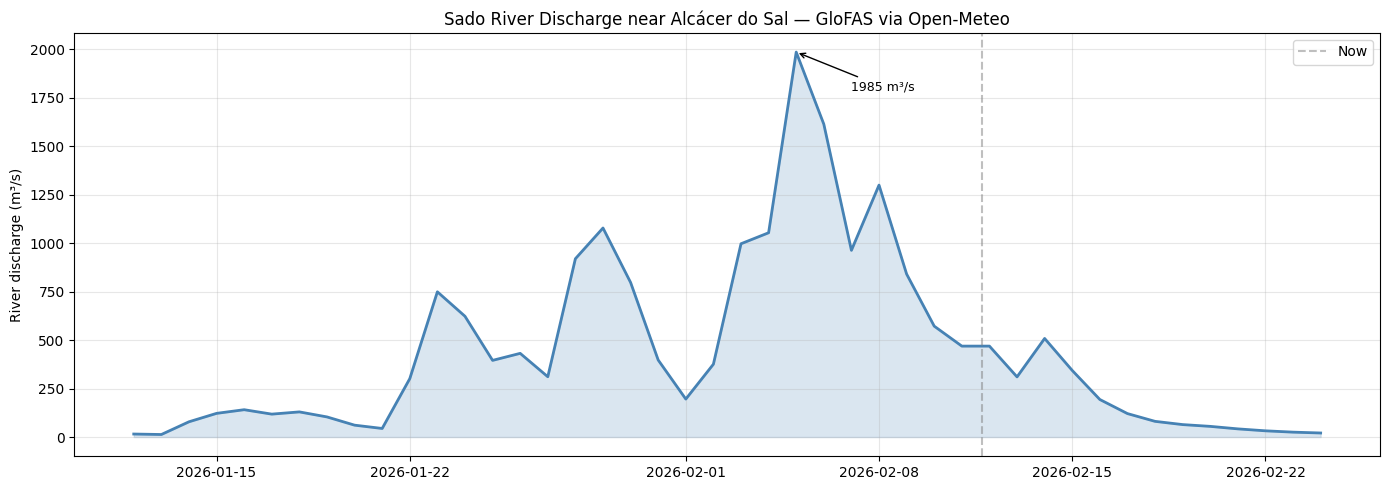


Current discharge: 20.8 m³/s
30-day median: 310.5 m³/s
Peak: 1985.1 m³/s on 2026-02-05
Current/median ratio: 0.1x


In [40]:
# --- 3. GloFAS discharge via Open-Meteo Flood API ---

flood_url = "https://flood-api.open-meteo.com/v1/flood"
flood_params = {
    "latitude": SADO_LAT,
    "longitude": SADO_LON,
    "daily": "river_discharge",
    "past_days": 30,  # get recent history
    "forecast_days": 14,
}

resp = requests.get(flood_url, params=flood_params)
resp.raise_for_status()
flood_data = resp.json()

print(f"GloFAS grid point: {flood_data['latitude']:.3f}°N, {flood_data['longitude']:.3f}°W")

flood_df = pd.DataFrame({
    "date": pd.to_datetime(flood_data["daily"]["time"]),
    "discharge_m3s": flood_data["daily"]["river_discharge"],
}).set_index("date")

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(flood_df.index, flood_df["discharge_m3s"], linewidth=2, color="steelblue")
ax.fill_between(flood_df.index, 0, flood_df["discharge_m3s"], alpha=0.2, color="steelblue")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5, label="Now")

# Annotate max
max_idx = flood_df["discharge_m3s"].idxmax()
max_val = flood_df["discharge_m3s"].max()
ax.annotate(f"{max_val:.0f} m³/s", xy=(max_idx, max_val),
            xytext=(max_idx + timedelta(days=2), max_val * 0.9),
            arrowprops=dict(arrowstyle="->"), fontsize=9)

ax.set_ylabel("River discharge (m³/s)")
ax.set_title(f"Sado River Discharge near {LOCATION_NAME} — GloFAS via Open-Meteo")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stats
current = flood_df["discharge_m3s"].dropna().iloc[-1]
median = flood_df["discharge_m3s"].median()
print(f"\nCurrent discharge: {current:.1f} m³/s")
print(f"30-day median: {median:.1f} m³/s")
print(f"Peak: {max_val:.1f} m³/s on {max_idx.strftime('%Y-%m-%d')}")
print(f"Current/median ratio: {current/median:.1f}x" if median > 0 else "Median is 0")

---
## 4. IPMA Weather Warnings

**Question:** What warnings are active right now? Anything for Setúbal district?  
**Source:** IPMA open-data API — the best Portuguese gov API.  
**Expected:** Precipitation warnings (yellow/orange) given ongoing flooding.

In [41]:
# --- 4. IPMA Weather Warnings ---

warnings_url = "https://api.ipma.pt/open-data/forecast/warnings/warnings_www.json"
resp = requests.get(warnings_url)
resp.raise_for_status()
warnings = resp.json()

print(f"Total active warnings: {len(warnings)}")

# Parse into DataFrame
w_df = pd.DataFrame(warnings)
if not w_df.empty:
    w_df["startTime"] = pd.to_datetime(w_df["startTime"])
    w_df["endTime"] = pd.to_datetime(w_df["endTime"])

    # Summary by type and level
    print("\n--- Warnings by type ---")
    for wtype, group in w_df.groupby("awarenessTypeName"):
        levels = group["awarenessLevelID"].value_counts().to_dict()
        print(f"  {wtype}: {dict(levels)}")

    # Filter for Setúbal district
    setubal_warnings = w_df[w_df["idAreaAviso"] == SETUBAL_DISTRICT].copy()
    print(f"\n--- Warnings for Setúbal district ({SETUBAL_DISTRICT}) ---")
    if setubal_warnings.empty:
        print("  No active warnings for Setúbal")
        # Try other district codes — IPMA uses various formats
        print(f"  Available district codes: {sorted(w_df['idAreaAviso'].unique())}")
    else:
        for _, w in setubal_warnings.iterrows():
            level = w["awarenessLevelID"].upper()
            emoji = {"YELLOW": "🟡", "ORANGE": "🟠", "RED": "🔴"}.get(level, "⚪")
            print(f"  {emoji} {level} — {w['awarenessTypeName']}")
            print(f"    {w['startTime']} → {w['endTime']}")
            print(f"    {w.get('text', 'No description')}")

    # Also show any RED or ORANGE warnings anywhere
    high = w_df[w_df["awarenessLevelID"].isin(["orange", "red"])]
    if not high.empty:
        print(f"\n--- HIGH-LEVEL warnings (orange/red) nationwide ---")
        for _, w in high.iterrows():
            level = w["awarenessLevelID"].upper()
            emoji = {"YELLOW": "🟡", "ORANGE": "🟠", "RED": "🔴"}.get(level, "⚪")
            print(f"  {emoji} {w['idAreaAviso']} — {w['awarenessTypeName']}: {w.get('text', '')[:80]}")
else:
    print("No warnings returned (empty response)")

Total active warnings: 297

--- Warnings by type ---
  Agitação Marítima: {'yellow': 28, 'green': 25, 'orange': 11}
  Neve: {'green': 25, 'yellow': 2}
  Nevoeiro: {'green': 25}
  Precipitação: {'green': 25, 'yellow': 21, 'orange': 9}
  Tempo Frio: {'green': 25}
  Tempo Quente: {'green': 25}
  Trovoada: {'green': 25}
  Vento: {'yellow': 26, 'green': 25}

--- Warnings for Setúbal district (STB) ---
  🟠 ORANGE — Agitação Marítima
    2026-02-13 12:00:00 → 2026-02-14 06:00:00
    Ondas de noroeste com 5 a 6 metros, podendo atingir 11 metros de altura máxima.
  🟡 YELLOW — Precipitação
    2026-02-11 12:10:00 → 2026-02-11 18:00:00
    Chuva persistente e por vezes forte.
  🟡 YELLOW — Agitação Marítima
    2026-02-11 15:00:00 → 2026-02-12 21:00:00
    Ondas de noroeste com 4 a 4,5 metros.
  🟡 YELLOW — Precipitação
    2026-02-13 00:00:00 → 2026-02-13 03:00:00
    Precipitação persistente e por vezes forte.
  🟡 YELLOW — Vento
    2026-02-13 00:00:00 → 2026-02-13 21:00:00
    Rajadas até 80 km/

---
## 5. Flood Precondition Index (v2)

**Question:** Does the precondition formula correctly flag Alcácer do Sal?

**v1 problem:** The original formula from discovery/07 returned GREEN (0.15) for an actively flooded location.  
Three structural issues identified:

1. **Deep soil bucket swamped the signal** — the 27–81cm layer contributed 102mm of "remaining capacity" that doesn't respond on storm timescales
2. **No backward-looking component** — the formula only asked about future rain, missing that 184mm had already fallen
3. **No discharge integration** — GloFAS showed a 1,985 m³/s peak but the index ignored it

**v2 formula — three-component composite:**

```
score_forward    = min(1, forecast_72h / remaining_capacity_0_27cm)
score_antecedent = min(1, past_7d_precip / 120mm)
score_discharge  = min(1, current_discharge / (3 × median_discharge))

composite = 0.3 × forward + 0.4 × antecedent + 0.3 × discharge

composite < 0.3  → Low (green)
composite 0.3–0.5 → Moderate (yellow)
composite 0.5–0.7 → High (orange)
composite > 0.7  → Very high (red)
```


In [48]:
# --- 5a. Revised Precondition Index (v2) ---
#
# Changes from v1:
#   1. Use only 0-27cm for remaining capacity (deep layer is hydrologically irrelevant for storms)
#   2. Add backward-looking antecedent component (recent rainfall + current discharge)
#   3. Integrate GloFAS discharge as a direct flood indicator
#   4. Surface-weighted saturation emphasizing the layers that generate runoff

# == Step 1: Surface-focused soil capacity ==
# Only 0-27cm matters for storm runoff. The 27-81cm layer responds
# on seasonal timescales, not storm timescales.

recent_sm = sm_df[sm_df.index <= pd.Timestamp.now()].dropna().iloc[-1]

layers_shallow = {
    "0-1 cm":   {"sm": recent_sm["sm_0_1"],  "depth_cm": 1},
    "1-3 cm":   {"sm": recent_sm["sm_1_3"],  "depth_cm": 2},
    "3-9 cm":   {"sm": recent_sm["sm_3_9"],  "depth_cm": 6},
    "9-27 cm":  {"sm": recent_sm["sm_9_27"], "depth_cm": 18},
}

print(f"=== Soil State at {recent_sm.name} ===\n")
print(f"{'Layer':12s} {'SM (m\u00b3/m\u00b3)':>12s} {'Saturation':>12s} {'Remaining':>12s}")
print("-" * 52)

shallow_remaining_mm = 0
for name, layer in layers_shallow.items():
    remaining = max(0, (POROSITY - layer["sm"]) * layer["depth_cm"] * 10)
    shallow_remaining_mm += remaining
    sat_pct = layer["sm"] / POROSITY * 100
    print(f"{name:12s} {layer['sm']:12.4f} {sat_pct:10.0f}% {remaining:10.1f} mm")

deep_remaining = max(0, (POROSITY - recent_sm["sm_27_81"]) * 54 * 10)
print(f"{'27-81 cm':12s} {recent_sm['sm_27_81']:12.4f} {recent_sm['sm_27_81']/POROSITY*100:10.0f}% {deep_remaining:10.1f} mm  <- EXCLUDED (too deep for storms)")

print(f"\n{'SHALLOW (0-27cm)':24s} {' ':12s} {shallow_remaining_mm:10.1f} mm")
print(f"{'TOTAL (0-81cm, v1)':24s} {' ':12s} {shallow_remaining_mm + deep_remaining:10.1f} mm")

# == Step 2: Forward-looking ratio (fixed) ==
forecast_3d = daily_df["precip_mm"][daily_df.index > pd.Timestamp.now()].head(3).sum()
forecast_7d = daily_df["precip_mm"][daily_df.index > pd.Timestamp.now()].head(7).sum()

ratio_3d_v2 = forecast_3d / shallow_remaining_mm if shallow_remaining_mm > 0 else float('inf')
ratio_7d_v2 = forecast_7d / shallow_remaining_mm if shallow_remaining_mm > 0 else float('inf')

print(f"\n=== Forward Component (v2 - shallow only) ===")
print(f"Remaining capacity (0-27cm): {shallow_remaining_mm:.1f} mm")
print(f"3-day forecast:  {forecast_3d:.1f} mm -> ratio {ratio_3d_v2:.2f}")
print(f"7-day forecast:  {forecast_7d:.1f} mm -> ratio {ratio_7d_v2:.2f}")

print(f"\n  Compare v1 (0-81cm): ratio = {forecast_7d / (shallow_remaining_mm + deep_remaining):.2f}")
print(f"  Compare v2 (0-27cm): ratio = {ratio_7d_v2:.2f}")
print(f"  -> {ratio_7d_v2 / (forecast_7d / (shallow_remaining_mm + deep_remaining)):.1f}x more sensitive")

# == Step 3: Backward-looking antecedent component ==

precip_hourly = pd.DataFrame({
    "time": pd.to_datetime(precip_data["hourly"]["time"]),
    "precip_mm": precip_data["hourly"]["precipitation"],
}).set_index("time")

past_7d_precip = precip_hourly[precip_hourly.index <= pd.Timestamp.now()].tail(168)["precip_mm"].sum()
past_3d_precip = precip_hourly[precip_hourly.index <= pd.Timestamp.now()].tail(72)["precip_mm"].sum()

current_discharge = flood_df["discharge_m3s"].dropna().iloc[-1]
peak_discharge = flood_df["discharge_m3s"].max()
median_discharge = flood_df["discharge_m3s"].median()

# Antecedent thresholds (mm in 7 days - Portugal-specific, need calibration)
PRECIP_7D_MODERATE = 40
PRECIP_7D_HIGH = 80
PRECIP_7D_EXTREME = 120

print(f"\n=== Backward Component - Antecedent Conditions ===")
print(f"Last 3 days precipitation: {past_3d_precip:.1f} mm")
print(f"Last 7 days precipitation: {past_7d_precip:.1f} mm")
if past_7d_precip > PRECIP_7D_EXTREME:
    antecedent_level = "EXTREME"
elif past_7d_precip > PRECIP_7D_HIGH:
    antecedent_level = "HIGH"
elif past_7d_precip > PRECIP_7D_MODERATE:
    antecedent_level = "MODERATE"
else:
    antecedent_level = "LOW"
print(f"Antecedent classification: {antecedent_level} (thresholds: {PRECIP_7D_MODERATE}/{PRECIP_7D_HIGH}/{PRECIP_7D_EXTREME} mm)")

print(f"\nGloFAS discharge:")
print(f"  Current:  {current_discharge:.1f} m\u00b3/s")
print(f"  Median:   {median_discharge:.1f} m\u00b3/s")
print(f"  Peak:     {peak_discharge:.1f} m\u00b3/s")
print(f"  Current/median: {current_discharge/median_discharge:.2f}x" if median_discharge > 0 else "  Median is 0")

# == Step 4: Composite index ==
score_forward = min(1.0, ratio_7d_v2)
score_antecedent = min(1.0, past_7d_precip / PRECIP_7D_EXTREME)
score_discharge = min(1.0, current_discharge / max(1, median_discharge * 3))

W_FORWARD = 0.3
W_ANTECEDENT = 0.4
W_DISCHARGE = 0.3

composite = (
    score_forward * W_FORWARD +
    score_antecedent * W_ANTECEDENT +
    score_discharge * W_DISCHARGE
)

def classify_composite(score):
    if score > 0.7: return "\U0001f534 VERY HIGH"
    if score > 0.5: return "\U0001f7e0 HIGH"
    if score > 0.3: return "\U0001f7e1 MODERATE"
    return "\U0001f7e2 LOW"

print(f"\n{'='*56}")
print(f"  COMPOSITE FLOOD PRECONDITION INDEX (v2)")
print(f"{'='*56}")
print(f"  Forward (forecast/capacity):   {score_forward:.2f}  x {W_FORWARD}")
print(f"  Antecedent (7d precip):        {score_antecedent:.2f}  x {W_ANTECEDENT}")
print(f"  Discharge (current/3xmedian):  {score_discharge:.2f}  x {W_DISCHARGE}")
print(f"{'─'*56}")
print(f"  COMPOSITE SCORE:               {composite:.2f}  -> {classify_composite(composite)}")
print(f"{'='*56}")

# == Step 5: What the v1 formula missed ==
print(f"\n=== Diagnosis: Why v1 returned GREEN ===")
print(f"  v1 remaining capacity: {shallow_remaining_mm + deep_remaining:.0f} mm (included 27-81cm: +{deep_remaining:.0f} mm)")
print(f"  v2 remaining capacity: {shallow_remaining_mm:.0f} mm (0-27cm only)")
print(f"  v1 ratio:  {forecast_7d / (shallow_remaining_mm + deep_remaining):.2f} -> GREEN (deep layer swamped signal)")
print(f"  v2 ratio:  {ratio_7d_v2:.2f}")
print(f"  v2 composite: {composite:.2f} -> {classify_composite(composite)}")
print(f"\n  Key: 184mm fell in 14 days. Peak discharge was {peak_discharge:.0f} m\u00b3/s.")
print(f"  The flood already happened - v1 couldn't see it because it only looks forward.")


=== Soil State at 2026-02-11 17:00:00 ===

Layer          SM (m³/m³)   Saturation    Remaining
----------------------------------------------------
0-1 cm             0.2200         52%        2.0 mm
1-3 cm             0.2190         52%        4.0 mm
3-9 cm             0.2200         52%       12.0 mm
9-27 cm            0.2240         53%       35.3 mm
27-81 cm           0.2310         55%      102.1 mm  <- EXCLUDED (too deep for storms)

SHALLOW (0-27cm)                            53.3 mm
TOTAL (0-81cm, v1)                         155.4 mm

=== Forward Component (v2 - shallow only) ===
Remaining capacity (0-27cm): 53.3 mm
3-day forecast:  22.6 mm -> ratio 0.42
7-day forecast:  22.6 mm -> ratio 0.42

  Compare v1 (0-81cm): ratio = 0.15
  Compare v2 (0-27cm): ratio = 0.42
  -> 2.9x more sensitive

=== Backward Component - Antecedent Conditions ===
Last 3 days precipitation: 12.6 mm
Last 7 days precipitation: 73.0 mm
Antecedent classification: MODERATE (thresholds: 40/80/120 mm)

GloFAS

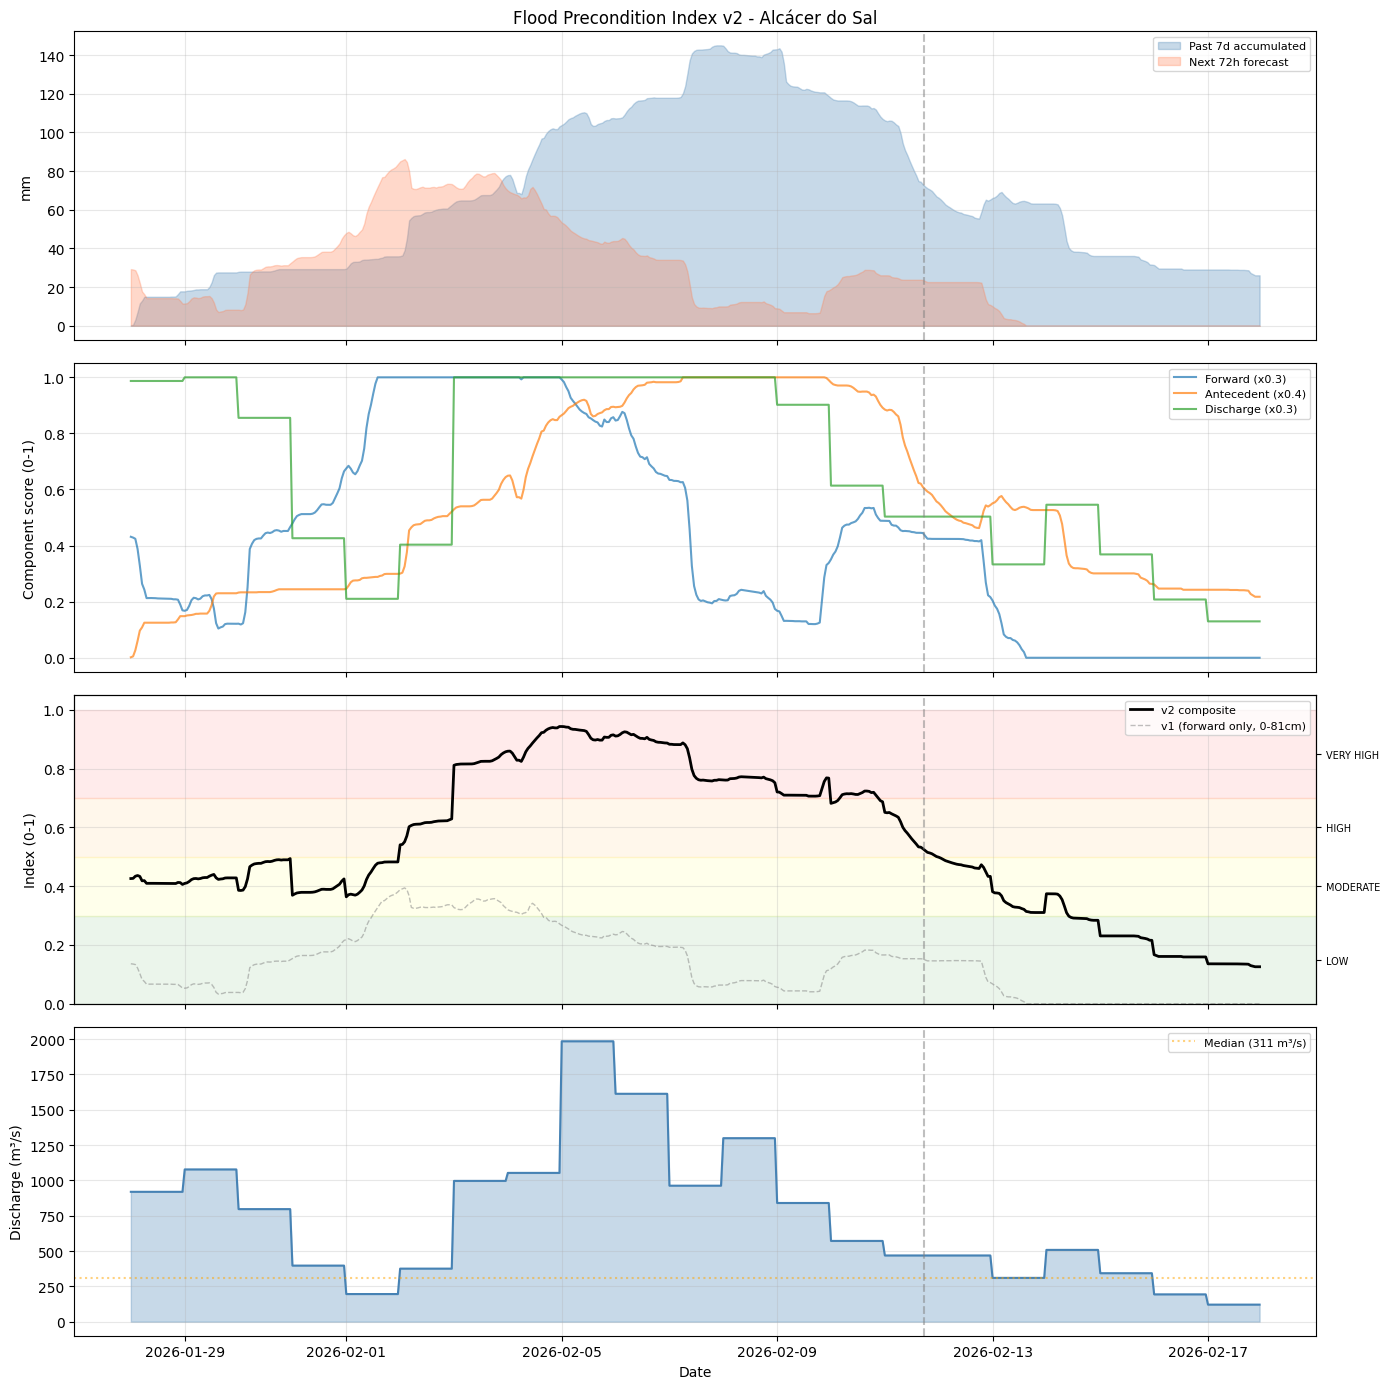


Peak composite index: 0.94 (🔴 VERY HIGH) at 2026-02-04 23:00:00
Current composite:   0.13 (🟢 LOW)


In [49]:
# --- 5b. Revised time-varying composite index ---

precip_hourly_full = pd.DataFrame({
    "time": pd.to_datetime(precip_data["hourly"]["time"]),
    "precip_mm": precip_data["hourly"]["precipitation"],
}).set_index("time")

# Forward-looking 72h precipitation for each hour
precip_hourly_full["fwd_72h"] = (
    precip_hourly_full["precip_mm"]
    .iloc[::-1]
    .rolling(72, min_periods=1)
    .sum()
    .iloc[::-1]
)

# Backward-looking 7-day precipitation for each hour
precip_hourly_full["bwd_7d"] = precip_hourly_full["precip_mm"].rolling(168, min_periods=1).sum()

# Merge with soil moisture
idx = sm_df[["sm_0_1", "sm_1_3", "sm_3_9", "sm_9_27", "sm_27_81"]].join(
    precip_hourly_full[["fwd_72h", "bwd_7d"]], how="inner"
).dropna()

# Shallow remaining capacity (0-27cm only)
idx["remaining_shallow_mm"] = (
    (POROSITY - idx["sm_0_1"]).clip(lower=0) * 1 * 10 +
    (POROSITY - idx["sm_1_3"]).clip(lower=0) * 2 * 10 +
    (POROSITY - idx["sm_3_9"]).clip(lower=0) * 6 * 10 +
    (POROSITY - idx["sm_9_27"]).clip(lower=0) * 18 * 10
)

# Three component scores
idx["score_forward"] = (idx["fwd_72h"] / idx["remaining_shallow_mm"].replace(0, 0.1)).clip(upper=1.0)
idx["score_antecedent"] = (idx["bwd_7d"] / PRECIP_7D_EXTREME).clip(upper=1.0)

# Discharge score - interpolate daily GloFAS to hourly
discharge_hourly = flood_df["discharge_m3s"].reindex(idx.index, method="ffill")
idx["score_discharge"] = (discharge_hourly / max(1, median_discharge * 3)).clip(upper=1.0)
idx["score_discharge"] = idx["score_discharge"].fillna(0)

# Composite
idx["composite"] = (
    idx["score_forward"] * W_FORWARD +
    idx["score_antecedent"] * W_ANTECEDENT +
    idx["score_discharge"] * W_DISCHARGE
)

# Also compute v1 for comparison
idx["remaining_total_mm"] = idx["remaining_shallow_mm"] + (POROSITY - idx["sm_27_81"]).clip(lower=0) * 54 * 10
idx["v1_ratio"] = (idx["fwd_72h"] / idx["remaining_total_mm"].replace(0, 0.1)).clip(upper=5.0)

# == Plot ==
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# 1. Precipitation (backward + forward)
ax = axes[0]
ax.fill_between(idx.index, 0, idx["bwd_7d"], alpha=0.3, color="steelblue", label="Past 7d accumulated")
ax.fill_between(idx.index, 0, idx["fwd_72h"], alpha=0.3, color="coral", label="Next 72h forecast")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("mm")
ax.set_title(f"Flood Precondition Index v2 - {LOCATION_NAME}")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2. Component scores
ax = axes[1]
ax.plot(idx.index, idx["score_forward"], label=f"Forward (x{W_FORWARD})", alpha=0.7)
ax.plot(idx.index, idx["score_antecedent"], label=f"Antecedent (x{W_ANTECEDENT})", alpha=0.7)
ax.plot(idx.index, idx["score_discharge"], label=f"Discharge (x{W_DISCHARGE})", alpha=0.7)
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Component score (0-1)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Composite index with risk zones
ax = axes[2]
ax.axhspan(0, 0.3, alpha=0.08, color="green")
ax.axhspan(0.3, 0.5, alpha=0.08, color="yellow")
ax.axhspan(0.5, 0.7, alpha=0.08, color="orange")
ax.axhspan(0.7, 1.0, alpha=0.08, color="red")
ax.plot(idx.index, idx["composite"], color="black", linewidth=2, label="v2 composite")
ax.plot(idx.index, idx["v1_ratio"].clip(upper=1.0), color="gray", linewidth=1, linestyle="--", alpha=0.5, label="v1 (forward only, 0-81cm)")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Index (0-1)")
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Add risk level labels on right axis
ax2 = ax.twinx()
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0.15, 0.4, 0.6, 0.85])
ax2.set_yticklabels(["LOW", "MODERATE", "HIGH", "VERY HIGH"], fontsize=7)

# 4. GloFAS discharge for context
ax = axes[3]
discharge_plot = flood_df["discharge_m3s"].reindex(idx.index, method="ffill")
ax.fill_between(idx.index, 0, discharge_plot, alpha=0.3, color="steelblue")
ax.plot(idx.index, discharge_plot, color="steelblue", linewidth=1.5)
ax.axhline(y=median_discharge, color="orange", linestyle=":", alpha=0.5, label=f"Median ({median_discharge:.0f} m\u00b3/s)")
ax.axvline(x=pd.Timestamp.now(), color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Discharge (m\u00b3/s)")
ax.set_xlabel("Date")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Peak composite and when it occurred
peak_composite_time = idx["composite"].idxmax()
peak_composite_val = idx["composite"].max()
print(f"\nPeak composite index: {peak_composite_val:.2f} ({classify_composite(peak_composite_val)}) at {peak_composite_time}")
print(f"Current composite:   {idx['composite'].iloc[-1]:.2f} ({classify_composite(idx['composite'].iloc[-1])})")


---
## 6. Earth Search STAC — Recent Sentinel-2 over Alcácer do Sal

**Question:** Can we find cloud-free Sentinel-2 imagery showing the flooding?  
**Source:** Element84 Earth Search v1  
**Expected:** Recent scenes exist but cloud cover may be high (it's been raining).  
Any scene with < 30% cloud cover would be usable for NDWI.

In [50]:
# --- 6. Earth Search STAC: Sentinel-2 search ---

from pystac_client import Client

stac = Client.open("https://earth-search.aws.element84.com/v1")

# Search for Sentinel-2 L2A over Alcácer do Sal, last 30 days
search = stac.search(
    collections=["sentinel-2-l2a"],
    bbox=[LON - 0.15, LAT - 0.10, LON + 0.15, LAT + 0.10],  # ~30x22 km box
    datetime=f"{(datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')}/{datetime.now().strftime('%Y-%m-%d')}",
    max_items=20,
    sortby=["-properties.datetime"],  # newest first
)

items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes in last 30 days\n")

# Summarize
print(f"{'Date':20s} {'Cloud %':>8s} {'Tile':6s} {'ID'}")
print("-" * 80)
best_item = None
for item in items:
    cloud = item.properties.get("eo:cloud_cover", -1)
    tile = item.properties.get("s2:mgrs_tile", "")
    dt = item.properties.get("datetime", "")[:19]
    marker = " ◀ BEST" if cloud >= 0 and (best_item is None or cloud < best_item.properties.get("eo:cloud_cover", 100)) else ""
    if marker:
        best_item = item
    print(f"{dt:20s} {cloud:7.1f}% {tile:6s} {item.id} {marker}")

if best_item:
    print(f"\n--- Best scene (lowest cloud cover) ---")
    print(f"ID: {best_item.id}")
    print(f"Date: {best_item.properties.get('datetime', '')[:19]}")
    print(f"Cloud cover: {best_item.properties.get('eo:cloud_cover', -1):.1f}%")
    print(f"\nAvailable bands:")
    for asset_key, asset in best_item.assets.items():
        if "image/tiff" in asset.media_type if asset.media_type else False:
            eo_bands = asset.extra_fields.get("eo:bands", [{}])
            band_name = eo_bands[0].get("name", "") if eo_bands else ""
            print(f"  {asset_key:12s}: {band_name:5s} — {asset.href[:80]}...")

Found 7 Sentinel-2 scenes in last 30 days

Date                  Cloud % Tile   ID
--------------------------------------------------------------------------------
2026-02-07T11:30:44     99.5%        S2C_29SNC_20260207_0_L2A  ◀ BEST
2026-02-02T11:31:06     59.7%        S2A_29SNC_20260202_1_L2A  ◀ BEST
2026-02-02T11:30:38     60.0%        S2B_29SNC_20260202_0_L2A 
2026-01-28T11:30:40    100.0%        S2C_29SNC_20260128_0_L2A 
2026-01-23T11:30:39     94.0%        S2B_29SNC_20260123_0_L2A 
2026-01-18T11:30:44      2.4%        S2C_29SNC_20260118_0_L2A  ◀ BEST
2026-01-13T11:30:41     90.8%        S2B_29SNC_20260113_0_L2A 

--- Best scene (lowest cloud cover) ---
ID: S2C_29SNC_20260118_0_L2A
Date: 2026-01-18T11:30:44
Cloud cover: 2.4%

Available bands:
  aot         :       — https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/29/S/NC/20...
  blue        : B02   — https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/29/S/NC/20...
  coastal     : B01   — ht

---
## 7. TiTiler NDWI — Compute Water Index On-the-Fly

**Question:** Can we compute NDWI directly via TiTiler expression endpoint without downloading bands?  
**Formula:** NDWI = (B3 - B8) / (B3 + B8)  
**Source:** DevSeed TiTiler demo instance or custom deployment  

This section attempts to use TiTiler to generate an NDWI tile from the best Sentinel-2 scene found above.
If cloud cover is too high, we note that and move on — SAR is the real flood detection path.

Green (B03): https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/29/S/NC/20...
NIR (B08):   https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/29/S/NC/20...

--- TiTiler STAC NDWI preview ---
Requesting: https://titiler.xyz/stac/preview.png


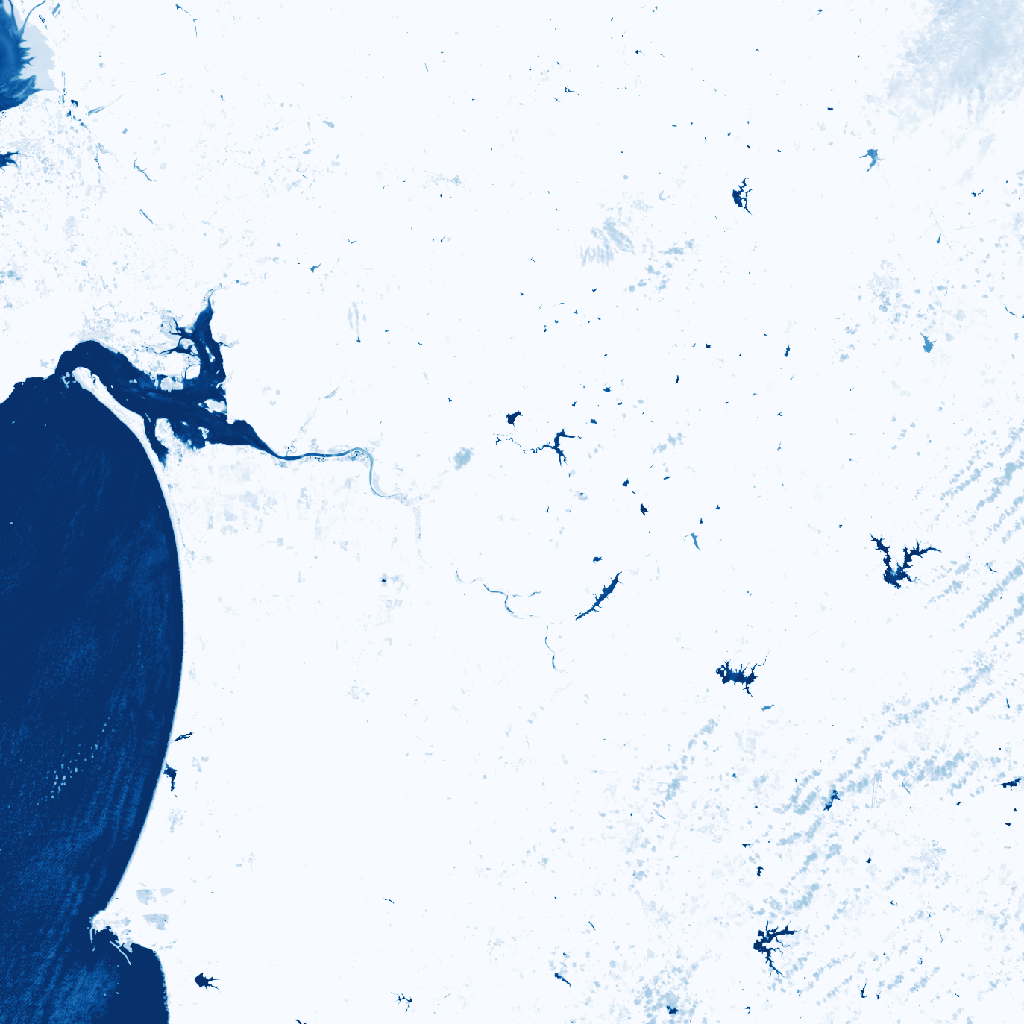

✅ NDWI preview rendered (507246 bytes)


In [51]:
# --- 7a. TiTiler NDWI from best Sentinel-2 scene ---

from IPython.display import display, Image as IPImage

if best_item is None:
    print("No Sentinel-2 scenes found — skip this section")
else:
    cloud = best_item.properties.get("eo:cloud_cover", 100)
    if cloud > 50:
        print(f"⚠️  Best scene has {cloud:.0f}% cloud cover — NDWI will be noisy")
        print("This confirms the discovery finding: optical is secondary for floods.")
        print("Proceeding anyway to validate the TiTiler integration pattern...")

    green_href = best_item.assets.get("green", best_item.assets.get("B03", None))
    nir_href = best_item.assets.get("nir", best_item.assets.get("B08", None))

    if green_href and nir_href:
        green_url = green_href.href
        nir_url = nir_href.href
        print(f"Green (B03): {green_url[:80]}...")
        print(f"NIR (B08):   {nir_url[:80]}...")

        TITILER_ENDPOINT = "https://titiler.xyz"

        # STAC endpoint with asset_as_band=True (required for expression to reference asset names)
        stac_url = f"{TITILER_ENDPOINT}/stac/preview.png"
        item_url = best_item.get_self_href() or f"https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/{best_item.id}"
        params = {
            "url": item_url,
            "expression": "(green-nir)/(green+nir)",
            "assets": ["green", "nir"],
            "asset_as_band": True,
            "rescale": "-0.5,0.8",
            "colormap_name": "blues",
            "max_size": 1024,
        }

        print(f"\n--- TiTiler STAC NDWI preview ---")
        print(f"Requesting: {stac_url}")

        try:
            resp = requests.get(stac_url, params=params, timeout=30)
            if resp.status_code == 200 and resp.headers.get('content-type', '').startswith('image'):
                display(IPImage(data=resp.content))
                print(f"✅ NDWI preview rendered ({len(resp.content)} bytes)")
            else:
                print(f"❌ TiTiler returned {resp.status_code}: {resp.text[:200]}")
                print("\nFallback: try direct COG preview...")
                cog_url = f"{TITILER_ENDPOINT}/cog/preview.png"
                resp2 = requests.get(cog_url, params={"url": green_url, "max_size": 512}, timeout=30)
                if resp2.status_code == 200 and resp2.headers.get('content-type', '').startswith('image'):
                    display(IPImage(data=resp2.content))
                    print("✅ Green band preview rendered (NDWI needs local processing — see 7b)")
                else:
                    print(f"❌ COG preview also failed: {resp2.status_code}")
        except Exception as e:
            print(f"❌ TiTiler request failed: {e}")
            print("Note: The public TiTiler instance may be rate-limited or down.")
            print("For production, deploy your own TiTiler instance.")
    else:
        print("Could not find green/nir assets in STAC item")
        print(f"Available assets: {list(best_item.assets.keys())}")


Reading COGs for NDWI computation (AOI: (-8.590300000000001, 38.312799999999996, -8.4303, 38.4328))...


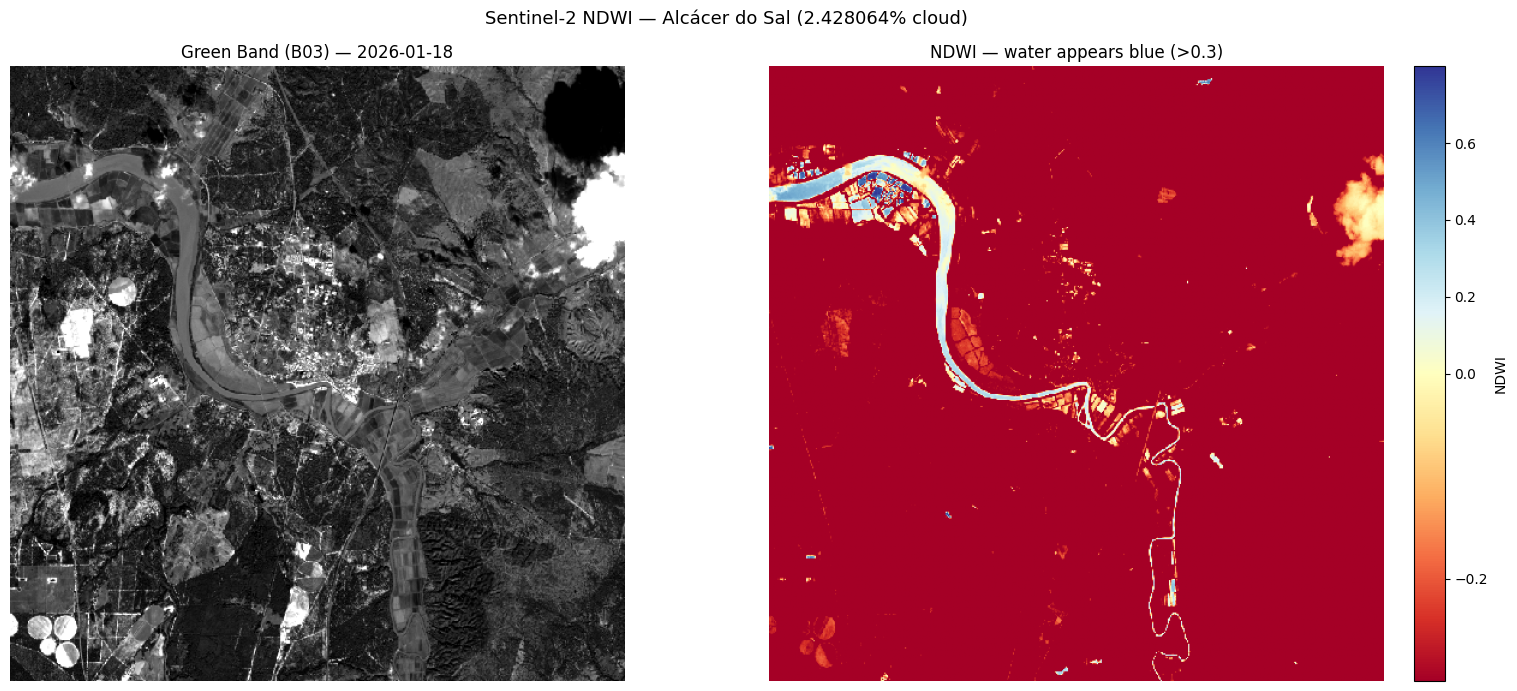


--- NDWI Statistics ---
  Water pixels (NDWI > 0.3): 1,465 / 262,144 (0.6%)
  Strong water (NDWI > 0.5): 382 (0.1%)
  NDWI range: [-0.998, 0.899]
  Mean NDWI: -0.613


In [52]:
# --- 7b. Alternative: compute NDWI locally from COGs using rasterio ---
# This is the reliable fallback if TiTiler doesn't cooperate

if best_item is not None:
    try:
        import rasterio
        from rasterio.windows import from_bounds
        from rasterio.crs import CRS
        from rasterio.warp import transform_bounds
        from matplotlib.colors import TwoSlopeNorm

        green_href = best_item.assets.get("green", best_item.assets.get("B03"))
        nir_href = best_item.assets.get("nir", best_item.assets.get("B08"))

        # Define AOI in EPSG:4326
        aoi_bounds = (LON - 0.08, LAT - 0.06, LON + 0.08, LAT + 0.06)  # ~18x13 km

        print(f"Reading COGs for NDWI computation (AOI: {aoi_bounds})...")

        with rasterio.open(green_href.href) as green_src:
            # Transform AOI bounds to the raster CRS
            native_bounds = transform_bounds(CRS.from_epsg(4326), green_src.crs, *aoi_bounds)
            window = from_bounds(*native_bounds, green_src.transform)

            # Read at overview level for speed (factor ~10x)
            green = green_src.read(1, window=window, out_shape=(512, 512)).astype("float32")
            green_transform = green_src.window_transform(window)

        with rasterio.open(nir_href.href) as nir_src:
            native_bounds = transform_bounds(CRS.from_epsg(4326), nir_src.crs, *aoi_bounds)
            window = from_bounds(*native_bounds, nir_src.transform)
            nir = nir_src.read(1, window=window, out_shape=(512, 512)).astype("float32")

        # Compute NDWI
        denominator = green + nir
        ndwi = np.where(denominator > 0, (green - nir) / denominator, 0)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # True color approximation (just green band)
        ax = axes[0]
        ax.imshow(green, cmap="gray", vmin=np.percentile(green[green>0], 2), vmax=np.percentile(green[green>0], 98))
        ax.set_title(f"Green Band (B03) — {best_item.properties.get('datetime', '')[:10]}")
        ax.axis("off")

        # NDWI
        ax = axes[1]
        norm = TwoSlopeNorm(vmin=-0.3, vcenter=0.0, vmax=0.8)
        im = ax.imshow(ndwi, cmap="RdYlBu", norm=norm)
        ax.set_title(f"NDWI — water appears blue (>0.3)")
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="NDWI")

        plt.suptitle(f"Sentinel-2 NDWI — {LOCATION_NAME} ({best_item.properties.get('eo:cloud_cover', '?')}% cloud)", fontsize=13)
        plt.tight_layout()
        plt.show()

        # Water pixel statistics
        valid = ndwi[denominator > 0]
        water_pixels = np.sum(valid > 0.3)
        total_pixels = valid.size
        print(f"\n--- NDWI Statistics ---")
        print(f"  Water pixels (NDWI > 0.3): {water_pixels:,} / {total_pixels:,} ({water_pixels/total_pixels*100:.1f}%)")
        print(f"  Strong water (NDWI > 0.5): {np.sum(valid > 0.5):,} ({np.sum(valid > 0.5)/total_pixels*100:.1f}%)")
        print(f"  NDWI range: [{valid.min():.3f}, {valid.max():.3f}]")
        print(f"  Mean NDWI: {valid.mean():.3f}")

    except ImportError:
        print("rasterio not installed — run: pip install rasterio")
    except Exception as e:
        print(f"❌ NDWI computation failed: {e}")
        print("This may be due to S3 access (requester-pays). Try with AWS credentials set.")

---
## Summary: Data Source Validation

Run this cell after completing all sections above.

In [53]:
# --- Summary scorecard ---

print("="*60)
print(f"DATA SOURCE VALIDATION — {LOCATION_NAME}")
print(f"Date: {TODAY}")
print("="*60)

checks = []

# 1. Soil moisture
try:
    val = sm_df["sm_rootzone"].dropna().iloc[-1]
    pct = val / POROSITY * 100
    status = "✅" if val > 0.25 else "⚠️"
    checks.append(("Open-Meteo Soil Moisture", status, f"{val:.3f} m³/m³ ({pct:.0f}% capacity)"))
except:
    checks.append(("Open-Meteo Soil Moisture", "❌", "Failed"))

# 2. Precipitation
try:
    checks.append(("Open-Meteo Precipitation", "✅", f"{past_total:.0f}mm (14d) + {future_total:.0f}mm (7d forecast)"))
except:
    checks.append(("Open-Meteo Precipitation", "❌", "Failed"))

# 3. Flood API
try:
    q = flood_df["discharge_m3s"].dropna().iloc[-1]
    checks.append(("Open-Meteo Flood API", "✅", f"{q:.0f} m³/s (Sado)"))
except:
    checks.append(("Open-Meteo Flood API", "❌", "Failed"))

# 4. IPMA
try:
    n = len(warnings)
    checks.append(("IPMA Warnings API", "✅", f"{n} warnings retrieved"))
except:
    checks.append(("IPMA Warnings API", "❌", "Failed"))

# 5. Precondition index (v2)
try:
    checks.append(("Precondition Index (v2)", "✅",
        f"composite={composite:.2f} ({classify_composite(composite)}), "
        f"fwd={score_forward:.2f}, ant={score_antecedent:.2f}, Q={score_discharge:.2f}"))
except Exception as e:
    checks.append(("Precondition Index (v2)", "❌", f"Failed: {e}"))

# 6. STAC
try:
    n_scenes = len(items)
    best_cloud = best_item.properties.get("eo:cloud_cover", -1) if best_item else -1
    checks.append(("Earth Search STAC", "✅", f"{n_scenes} scenes, best cloud: {best_cloud:.0f}%"))
except:
    checks.append(("Earth Search STAC", "❌", "Failed"))

print()
for name, status, detail in checks:
    print(f"  {status} {name:30s} {detail}")

print()
print("Next steps:")
print("  1. If precondition index is red → formula validated, proceed to backend")
print("  2. If all APIs returned data → architecture confirmed")
print("  3. Cloud cover issue → confirms SAR-first strategy from discovery")
print("  4. Save this notebook as ground truth for the Sado basin test case")


DATA SOURCE VALIDATION — Alcácer do Sal
Date: 2026-02-11

  ⚠️ Open-Meteo Soil Moisture       0.242 m³/m³ (58% capacity)
  ✅ Open-Meteo Precipitation       184mm (14d) + 26mm (7d forecast)
  ✅ Open-Meteo Flood API           21 m³/s (Sado)
  ✅ IPMA Warnings API              297 warnings retrieved
  ✅ Precondition Index (v2)        composite=0.38 (🟡 MODERATE), fwd=0.42, ant=0.61, Q=0.02
  ✅ Earth Search STAC              7 scenes, best cloud: 2%

Next steps:
  1. If precondition index is red → formula validated, proceed to backend
  2. If all APIs returned data → architecture confirmed
  3. Cloud cover issue → confirms SAR-first strategy from discovery
  4. Save this notebook as ground truth for the Sado basin test case
